# 01 Alaska Peninsula

Authors: Kidus Teshome, Cian Wilson

## Steady state implementation

### Preamble

Set some path information.

In [1]:
import sys, os
basedir = ''
if "__file__" in globals(): basedir = os.path.dirname(__file__)
sys.path.append(os.path.join(basedir, os.path.pardir))
sys.path.append(os.path.join(basedir, os.path.pardir, os.path.pardir, 'python'))

Loading everything we need from `sz_problem` and also set our default plotting and output preferences.

In [2]:
import utils
from sz_base import allsz_params
from sz_slab import create_slab, plot_slab
from sz_geometry import create_sz_geometry
from sz_problem import SubductionProblem
import numpy as np
import dolfinx as df
import pyvista as pv
if __name__ == "__main__" and "__file__" in globals():
    pv.OFF_SCREEN = True
import pathlib
output_folder = pathlib.Path(os.path.join(basedir, "output"))
output_folder.mkdir(exist_ok=True, parents=True)

### Parameters

We first select the name and resolution scale, `resscale` of the model.

```{admonition} Resolution
By default the resolution is low to allow for a quick runtime and smaller website size.  If sufficient computational resources are available set a lower `resscale` to get higher resolutions and results with sufficient accuracy.
```


In [3]:
name = "01_Alaska_Peninsula"
resscale = 3.0
cfl      = 3.0

Then load the remaining parameters from the global suite.

In [4]:
szdict = allsz_params[name]

### Setup

Setup a slab.

In [5]:
slab = create_slab(szdict['xs'], szdict['ys'], resscale, szdict['lc_depth'])

Create the subduction zome geometry around the slab.

In [6]:
geom = create_sz_geometry(slab, resscale, szdict['sztype'], szdict['io_depth'], szdict['extra_width'], 
                             szdict['coast_distance'], szdict['lc_depth'], szdict['uc_depth'])

### Solve steady state

Solve using a dislocation creep rheology and assuming a steady state.

In [7]:
szss = SubductionProblem(geom, **szdict)
szss.solve_steadystate_dislocationcreep()

Iteration   Residual     Relative Residual
------------------------------------------
0           5920.84      1           
1           1507.18      0.254555    
2           138.688      0.0234238   
3           66.0739      0.0111596   
4           24.6242      0.00415891  
5           9.26786      0.00156529  
6           4.76539      0.00080485  
7           3.12398      0.000527626 
8           2.20935      0.000373148 
9           1.59711      0.000269744 
10          1.1689       0.000197422 
11          0.863821     0.000145895 
12          0.64343      0.000108672 
13          0.482278     8.14544e-05 
14          0.363346     6.13673e-05 
15          0.274931     4.64345e-05 
16          0.20879      3.52636e-05 
17          0.15905      2.68627e-05 
18          0.121484     2.0518e-05  
19          0.0930129    1.57094e-05 
20          0.0713752    1.20549e-05 
21          0.0548936    9.27126e-06 
22          0.042315     7.14679e-06 
23          0.0326983    5.52258e-06 
24

### Plot

Plot the solution.

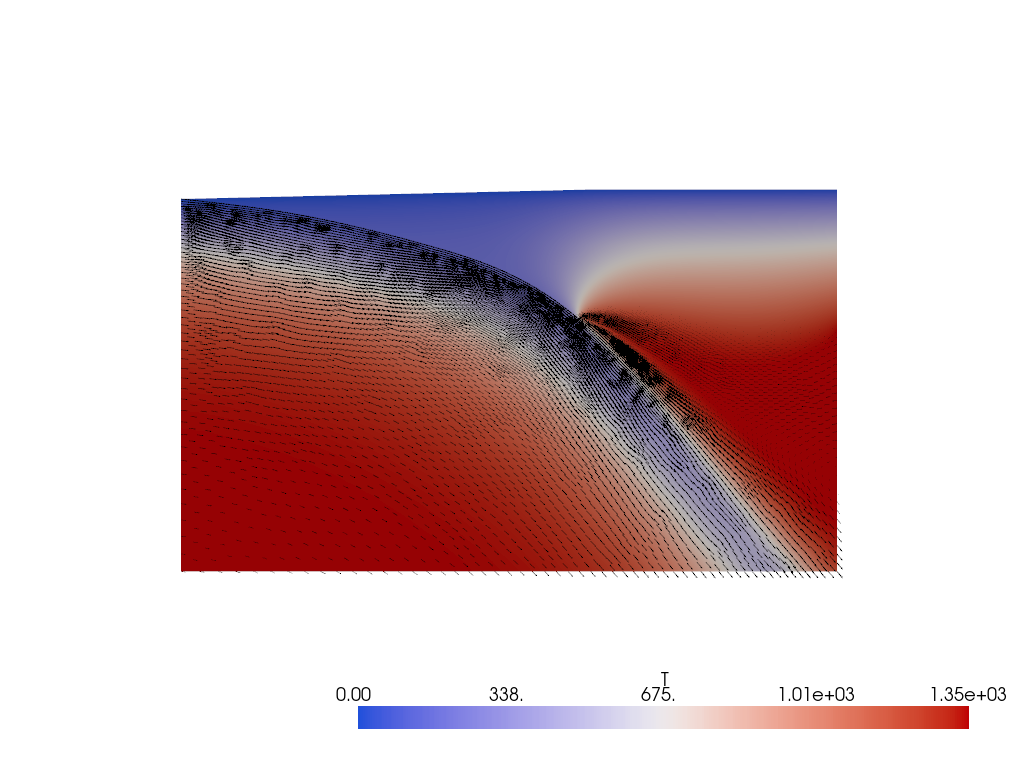

In [8]:
plotter = utils.plot_scalar(szss.T_i, scale=szss.T0, gather=True, cmap='coolwarm')
utils.plot_vector_glyphs(szss.vw_i, plotter=plotter, gather=True, factor=0.1, color='k', scale=utils.mps_to_mmpyr(szss.v0))
utils.plot_vector_glyphs(szss.vs_i, plotter=plotter, gather=True, factor=0.1, color='k', scale=utils.mps_to_mmpyr(szss.v0))
utils.plot_show(plotter)
utils.plot_save(plotter, output_folder / "{}_ss_solution_resscale_{:.2f}.png".format(name, resscale))

### Solve time-dependent

Solve using a dislocation creep rheology.

In [9]:
sztd = SubductionProblem(geom, **szdict)
# Select the timestep based on the approximate target Courant number
dt = cfl*resscale/szdict['Vs']
# Reduce the timestep to get an integer number of timesteps
dt = szdict['As']/np.ceil(szdict['As']/dt)
sztd.solve_timedependent_dislocationcreep(szdict['As'], dt, theta=0.5, rtol=1.e-1, verbosity=1)

Entering timeloop with 263 steps (dt = 0.152091 Myr, final time = 40 Myr)
Finished timeloop after 263 steps (final time = 40 Myr)


### Plot

Plot the solution.

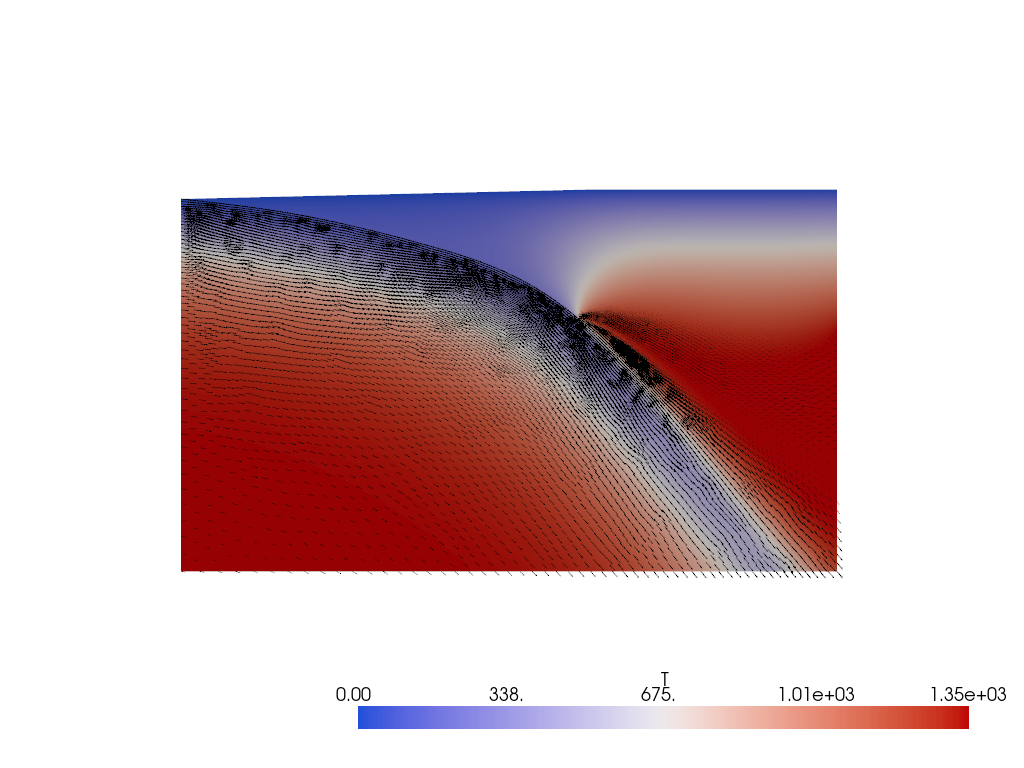

In [11]:
plotter = utils.plot_scalar(sztd.T_i, scale=sztd.T0, gather=True, cmap='coolwarm')
utils.plot_vector_glyphs(sztd.vw_i, plotter=plotter, gather=True, factor=0.1, color='k', scale=utils.mps_to_mmpyr(sztd.v0))
utils.plot_vector_glyphs(sztd.vs_i, plotter=plotter, gather=True, factor=0.1, color='k', scale=utils.mps_to_mmpyr(sztd.v0))
utils.plot_show(plotter)
utils.plot_save(plotter, output_folder / "{}_td_solution_resscale_{:.2f}_cfl_{:.2f}.png".format(name, resscale, cfl,))

## Comparison

In [12]:
T_diff = df.fem.Function(sztd.V_T)
T_diff.x.array[:] = szss.T_i.x.array - sztd.T_i.x.array

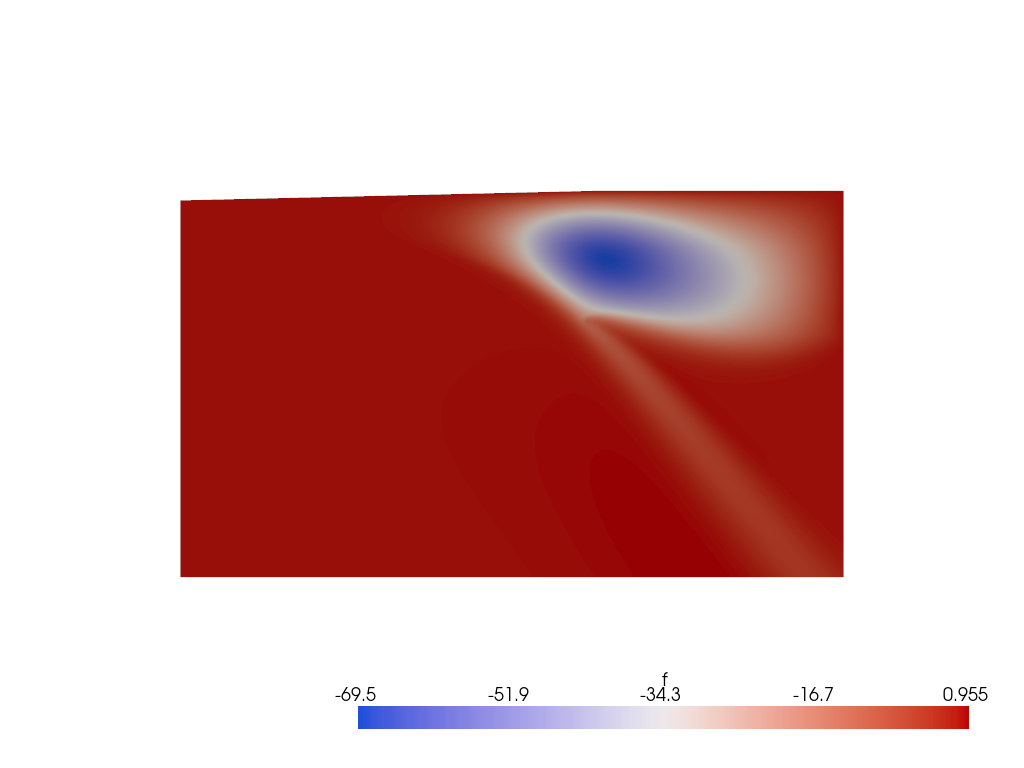

In [13]:
plotter = utils.plot_scalar(T_diff, scale=szss.T0, gather=True, cmap='coolwarm')
utils.plot_show(plotter)
utils.plot_save(plotter, output_folder / "{}_ss-td_solution_resscale_{:.2f}_cfl_{:.2f}.png".format(name, resscale, cfl,))